#Project 3: Energy Prediction

Team 9: Aman Chaturvedi (2888825),
Janani Sridhar (2892366)

# Introduction

A historic cold snap that has left millions of Texans without electricity, water, and heat for days, claims that the state’s use of renewable energy sources, specifically wind energy. The winter storm that began on 13 February, which brought some of the coldest weather the state has experienced since 1989.

As USA Today reported here , Texas has emerged in recent years as not just a national but a global leader in building renewable energy. Wind generates 20% of total electricity in Texas, where natural gas supplies 47.4%, coal supplies 20.3% and solar supplies 1.1%. The storm has knocked about a third of the state’s generating capacity offline. Natural gas wells and pipelines in Texas, the country’s biggest energy-producing state, did not undergo the winterization of those farther.
While Texas leads the U.S. in the production of natural gas, that gas couldn't be used to provide electrical power and to heat homes in Texas because of the way natural gas is stored. It is stored in underground chambers, and to bring it to the surface, a pump is required. Due to natural gas wells and pipes that are ill-equipped for cold weather, “liquid inside wells, pipes, and valves froze solid. 

With the advent of machine learning, accurately predicting future energy consumption becomes increasingly possible. Forecasts provide a benchmark to single out anomalously high/low energy consumption and alert people.
The prediction and scheduling are two of the main pillars of efficient Energy Management Systems (EMS). Advances in machine learning studies have a tremendous impact on the field of smart building energy management as it is crucial to reduce energy consumption of various types of building from residential buildings to industrial buildings.

Our task is to predict demand for energy in 2015 using historic energy data and based on weather variables. We are given with two datasets - Demand data and weather data.


## Citation

1. https://en.wikipedia.org/wiki/2021_Texas_power_crisis

2. https://www.texastribune.org/series/winter-storm-power-outage/

3. https://www.texastribune.org/2021/03/29/texas-power-outage-ERCOT/

4. https://www.usatoday.com/in-depth/news/nation/2021/02/16/texas-weather-power-outage-rolling-blackouts-leave-millions-dark/6764764002/

5. https://towardsdatascience.com/forecasting-energy-consumption-using-neural-networks-xgboost-2032b6e6f7e2

6. https://www.cnbc.com/2021/03/26/how-texas-tough-winter-exposed-us-power-grid-problems-.html


Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import calendar
from datetime import datetime

# RNN-specific modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report,accuracy_score
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Demand Data

## Reading the demand data

In [ ]:
# https://drive.google.com/file/d/1M7-XiHcfboUzKZ-tmflDomy_IuRAvnw9/view?usp=sharing
!gdown --id 1M7-XiHcfboUzKZ-tmflDomy_IuRAvnw9

Downloading...
From: https://drive.google.com/uc?id=1M7-XiHcfboUzKZ-tmflDomy_IuRAvnw9
To: /content/Ercot_2011_2021_feb.csv
3.52MB [00:00, 13.3MB/s]


In [ ]:
energy = pd.read_csv('Ercot_2011_2021_feb.csv') # it just downloaded locally to your workspace!
energy.head()

,Unnamed: 0,Date,HE,MWh
0,0,2010-01-01,1,32094.064435
1,1,2010-01-01,2,32171.322546
2,2,2010-01-01,3,32241.752463
3,3,2010-01-01,4,32459.193227
4,4,2010-01-01,5,33123.751047


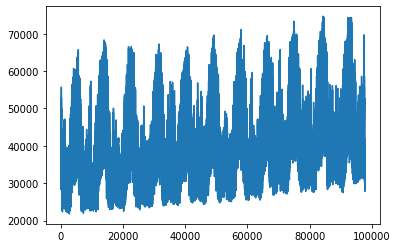

In [ ]:
# this is your target variable
energy['MWh'].plot()

In [ ]:
print(energy['Date'].min())
print(energy['Date'].max())

2010-01-01
2021-03-01


## Data Cleaning : Demand Data

In [ ]:
energy['HE'] = energy['HE'].astype(str)

In [ ]:
energy['valid_date'] = energy['Date'] + ' ' + energy['HE'] + ':' + '00:00'

In [ ]:
energy['valid_date'] = pd.to_datetime(energy['valid_date'])

In [ ]:
energy = energy.drop(["Date", "HE"], axis = 1)

In [ ]:
#Extract the dates from 2011 to 2014

from datetime import datetime

start_date = "2011-01-01 00:00:00" 
end_date = "2015-12-31 00:23:00" 

start_date_obj = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
end_date_obj = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')

after_start_date = energy["valid_date"] >= start_date_obj
before_end_date = energy["valid_date"] <= end_date_obj
between_two_dates = after_start_date & before_end_date
energy_final = energy.loc[between_two_dates]

In [ ]:
energy_final.isnull().sum()

Unnamed: 0    0
MWh           0
valid_date    0
dtype: int64

In [ ]:
energy_final.head()

,Unnamed: 0,MWh,valid_date
8759,8759,28496.388850,2011-01-01 00:00:00
8760,8760,27662.443480,2011-01-01 01:00:00
8761,8761,27250.044715,2011-01-01 02:00:00
8762,8762,26783.226081,2011-01-01 03:00:00
8763,8763,26676.468490,2011-01-01 04:00:00


In [ ]:
energy_final = energy_final.drop(["Unnamed: 0"], axis = 1)

In [ ]:
energy_final

,MWh,valid_date
8759,28496.388850,2011-01-01 00:00:00
8760,27662.443480,2011-01-01 01:00:00
8761,27250.044715,2011-01-01 02:00:00
8762,26783.226081,2011-01-01 03:00:00
8763,26676.468490,2011-01-01 04:00:00
...,...,...
52555,39674.167296,2015-12-30 20:00:00
52556,39485.829257,2015-12-30 21:00:00
52557,38711.458864,2015-12-30 22:00:00
52558,37254.930151,2015-12-30 23:00:00


In [ ]:
print(energy_final['MWh'].min())
print(energy_final['MWh'].max())

22366.014253999994
69620.40761393859


# Weather Data

## Reading the weather data

In [ ]:
# https://drive.google.com/file/d/1vl2RKquLYS1QRyYE7ySIj24jPnXFp2od/view?usp=sharing
!gdown --id 1vl2RKquLYS1QRyYE7ySIj24jPnXFp2od

Downloading...
From: https://drive.google.com/uc?id=1vl2RKquLYS1QRyYE7ySIj24jPnXFp2od
To: /content/FST.csv
97.2MB [00:01, 76.7MB/s]


In [ ]:
weather = pd.read_csv('FST.csv')
weather.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,station,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,vsby,gust,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,wxcodes,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar
0,FST,2010-01-01 00:53,30.02,24.98,81.27,180.00,5.00,M,30.50,1031.80,10.00,M,CLR,,,M,M,M,M,M,M,M,M,M,M,M,M,24.04,METAR KFST 010553Z AUTO 18005KT 10SM CLR M01/M...
1,FST,2010-01-01 01:53,28.04,24.08,84.87,190.00,5.00,M,30.49,1031.30,10.00,M,CLR,,,M,M,M,M,M,M,M,M,M,M,M,M,21.69,METAR KFST 010653Z AUTO 19005KT 10SM CLR M02/M...
2,FST,2010-01-01 02:53,26.96,23.00,84.80,220.00,9.00,M,30.47,1030.90,10.00,M,CLR,,,M,M,M,M,M,M,M,M,M,M,M,M,17.25,METAR KFST 010753Z AUTO 22009KT 10SM CLR M03/M...
3,FST,2010-01-01 03:53,26.96,23.00,84.80,210.00,8.00,M,30.46,1030.40,10.00,M,CLR,,,M,M,M,M,M,M,M,M,M,M,M,M,17.90,METAR KFST 010853Z AUTO 21008KT 10SM CLR M03/M...
4,FST,2010-01-01 04:53,28.04,23.00,81.11,220.00,12.00,M,30.44,1030.00,10.00,M,CLR,,,M,M,M,M,M,M,M,M,M,M,M,M,16.96,METAR KFST 010953Z AUTO 22012KT 10SM CLR M02/M...


## Data Cleaning : Weather Data

In [ ]:
# convert time stamp to datetime for interpolation
weather['valid'] = pd.to_datetime(weather['valid'])
weather.dtypes

station                      object
valid                datetime64[ns]
tmpf                         object
dwpf                         object
relh                         object
drct                         object
sknt                         object
p01i                         object
alti                         object
mslp                         object
vsby                         object
gust                         object
skyc1                        object
skyc2                        object
skyc3                        object
skyc4                        object
skyl1                        object
skyl2                        object
skyl3                        object
skyl4                        object
wxcodes                      object
ice_accretion_1hr            object
ice_accretion_3hr            object
ice_accretion_6hr            object
peak_wind_gust               object
peak_wind_drct               object
peak_wind_time               object
feel                        

In [ ]:
# look at the datetime range
print(weather['valid'].min())
print(weather['valid'].max())

2010-01-01 00:53:00
2021-02-19 23:55:00


In [ ]:
# set the datetime as the index so you can do interpolation later
weather.set_index(weather['valid'], inplace=True)
weather.head() # see how the valid column is now the index? this will allow
                # you to do resampling to hourly resolution

,station,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,vsby,gust,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,wxcodes,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar
valid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:53:00,FST,2010-01-01 00:53:00,30.02,24.98,81.27,180.00,5.00,M,30.50,1031.80,10.00,M,CLR,,,M,M,M,M,M,M,M,M,M,M,M,M,24.04,METAR KFST 010553Z AUTO 18005KT 10SM CLR M01/M...
2010-01-01 01:53:00,FST,2010-01-01 01:53:00,28.04,24.08,84.87,190.00,5.00,M,30.49,1031.30,10.00,M,CLR,,,M,M,M,M,M,M,M,M,M,M,M,M,21.69,METAR KFST 010653Z AUTO 19005KT 10SM CLR M02/M...
2010-01-01 02:53:00,FST,2010-01-01 02:53:00,26.96,23.00,84.80,220.00,9.00,M,30.47,1030.90,10.00,M,CLR,,,M,M,M,M,M,M,M,M,M,M,M,M,17.25,METAR KFST 010753Z AUTO 22009KT 10SM CLR M03/M...
2010-01-01 03:53:00,FST,2010-01-01 03:53:00,26.96,23.00,84.80,210.00,8.00,M,30.46,1030.40,10.00,M,CLR,,,M,M,M,M,M,M,M,M,M,M,M,M,17.90,METAR KFST 010853Z AUTO 21008KT 10SM CLR M03/M...
2010-01-01 04:53:00,FST,2010-01-01 04:53:00,28.04,23.00,81.11,220.00,12.00,M,30.44,1030.00,10.00,M,CLR,,,M,M,M,M,M,M,M,M,M,M,M,M,16.96,METAR KFST 010953Z AUTO 22012KT 10SM CLR M02/M...


In [ ]:
weather_final=weather.loc['2011-01-01 00:00:00':'2015-12-31 23:59:59']

In [ ]:
weather_final.head()

,station,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,vsby,gust,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,wxcodes,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar
valid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:53:00,FST,2011-01-01 00:53:00,32.00,17.96,55.72,230.00,8.00,M,30.02,1015.50,10.00,-99.00,CLR,,,,M,M,M,M,M,M,M,M,M,M,M,24.11,KFST 010553Z AUTO 23008KT 10SM CLR 00/M08 A300...
2011-01-01 01:53:00,FST,2011-01-01 01:53:00,33.08,19.04,55.89,250.00,7.00,M,30.03,1015.60,10.00,-99.00,CLR,,,,M,M,M,M,M,M,M,M,M,M,M,26.10,KFST 010653Z AUTO 25007KT 10SM CLR 01/M07 A300...
2011-01-01 02:53:00,FST,2011-01-01 02:53:00,33.08,17.96,53.36,270.00,9.00,M,30.05,1016.20,10.00,-99.00,CLR,,,,M,M,M,M,M,M,M,M,M,M,M,24.86,KFST 010753Z AUTO 27009KT 10SM CLR 01/M08 A300...
2011-01-01 03:53:00,FST,2011-01-01 03:53:00,32.00,19.04,58.37,250.00,7.00,M,30.06,1016.60,10.00,-99.00,CLR,,,,M,M,M,M,M,M,M,M,M,M,M,24.78,KFST 010853Z AUTO 25007KT 10SM CLR 00/M07 A300...
2011-01-01 04:53:00,FST,2011-01-01 04:53:00,30.02,19.04,63.24,260.00,7.00,M,30.07,1017.20,10.00,-99.00,CLR,,,,M,M,M,M,M,M,M,M,M,M,M,22.37,KFST 010953Z AUTO 26007KT 10SM CLR M01/M07 A30...


Extracting data by hour

In [ ]:
weather_final = weather_final.resample('60T').max()

In [ ]:
weather_final.head()

,station,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,vsby,gust,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,wxcodes,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar
valid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,FST,2011-01-01 00:53:00,32.00,17.96,55.72,230.00,8.00,M,30.02,1015.50,10.00,-99.00,CLR,,,,M,M,M,M,M,M,M,M,M,M,M,24.11,KFST 010553Z AUTO 23008KT 10SM CLR 00/M08 A300...
2011-01-01 01:00:00,FST,2011-01-01 01:53:00,33.08,19.04,55.89,250.00,7.00,M,30.03,1015.60,10.00,-99.00,CLR,,,,M,M,M,M,M,M,M,M,M,M,M,26.10,KFST 010653Z AUTO 25007KT 10SM CLR 01/M07 A300...
2011-01-01 02:00:00,FST,2011-01-01 02:53:00,33.08,17.96,53.36,270.00,9.00,M,30.05,1016.20,10.00,-99.00,CLR,,,,M,M,M,M,M,M,M,M,M,M,M,24.86,KFST 010753Z AUTO 27009KT 10SM CLR 01/M08 A300...
2011-01-01 03:00:00,FST,2011-01-01 03:53:00,32.00,19.04,58.37,250.00,7.00,M,30.06,1016.60,10.00,-99.00,CLR,,,,M,M,M,M,M,M,M,M,M,M,M,24.78,KFST 010853Z AUTO 25007KT 10SM CLR 00/M07 A300...
2011-01-01 04:00:00,FST,2011-01-01 04:53:00,30.02,19.04,63.24,260.00,7.00,M,30.07,1017.20,10.00,-99.00,CLR,,,,M,M,M,M,M,M,M,M,M,M,M,22.37,KFST 010953Z AUTO 26007KT 10SM CLR M01/M07 A30...


You are welcome to use all fields if you would like (not recommended), but I recommend you focus on:
* tmpf
*	dwpf
*	relh

Since these are the three variables that determine who turns on their heat or airconditioner. You should coerce these three variables to numeric (the missing values are currently coded as 'M'), which is why the data type is object right now.

## Preparing the weather data

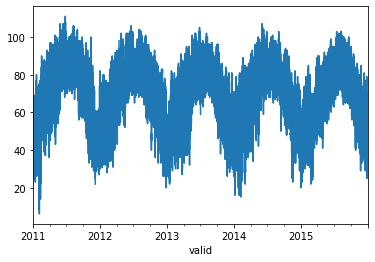

In [ ]:
weather_final['tmpf'] = pd.to_numeric(weather_final['tmpf'], errors='coerce')
weather_final['tmpf'].plot()

Scroll down and you will find the data dictionary on this webpage: https://mesonet.agron.iastate.edu/request/download.phtml

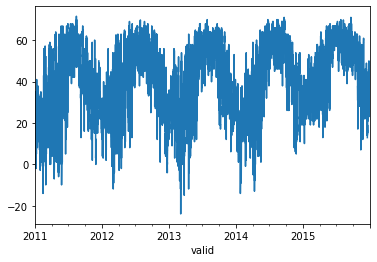

In [ ]:
weather_final['dwpf'] = pd.to_numeric(weather_final['dwpf'], errors='coerce')
weather_final['dwpf'].plot()

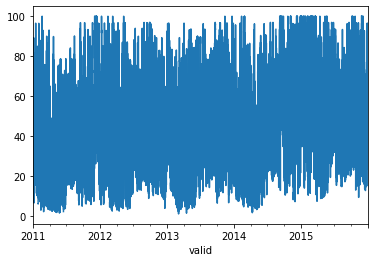

In [ ]:
weather_final['relh'] = pd.to_numeric(weather_final['relh'], errors='coerce')
weather_final['relh'].plot()

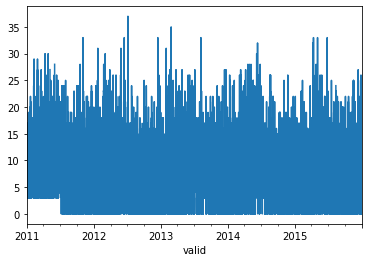

In [ ]:

weather_final['sknt'] = pd.to_numeric(weather_final['sknt'], errors='coerce')
weather_final['sknt'].plot()

In [ ]:
weather_final.head()

,station,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,vsby,gust,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,wxcodes,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar
valid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,FST,2011-01-01 00:53:00,32.00,17.96,55.72,230.00,8.0,M,30.02,1015.50,10.00,-99.00,CLR,,,,M,M,M,M,M,M,M,M,M,M,M,24.11,KFST 010553Z AUTO 23008KT 10SM CLR 00/M08 A300...
2011-01-01 01:00:00,FST,2011-01-01 01:53:00,33.08,19.04,55.89,250.00,7.0,M,30.03,1015.60,10.00,-99.00,CLR,,,,M,M,M,M,M,M,M,M,M,M,M,26.10,KFST 010653Z AUTO 25007KT 10SM CLR 01/M07 A300...
2011-01-01 02:00:00,FST,2011-01-01 02:53:00,33.08,17.96,53.36,270.00,9.0,M,30.05,1016.20,10.00,-99.00,CLR,,,,M,M,M,M,M,M,M,M,M,M,M,24.86,KFST 010753Z AUTO 27009KT 10SM CLR 01/M08 A300...
2011-01-01 03:00:00,FST,2011-01-01 03:53:00,32.00,19.04,58.37,250.00,7.0,M,30.06,1016.60,10.00,-99.00,CLR,,,,M,M,M,M,M,M,M,M,M,M,M,24.78,KFST 010853Z AUTO 25007KT 10SM CLR 00/M07 A300...
2011-01-01 04:00:00,FST,2011-01-01 04:53:00,30.02,19.04,63.24,260.00,7.0,M,30.07,1017.20,10.00,-99.00,CLR,,,,M,M,M,M,M,M,M,M,M,M,M,22.37,KFST 010953Z AUTO 26007KT 10SM CLR M01/M07 A30...


In [ ]:
weather_final = weather_final.drop(["feel","p01i", "alti", "mslp", "vsby", "gust", "ice_accretion_1hr", "wxcodes",
        "ice_accretion_3hr", "ice_accretion_6hr", "peak_wind_gust", "peak_wind_drct", "skyl1", "skyl2", "skyl3", "skyl4","skyc1","skyc2","skyc3","skyc4"], axis = 1)

In [ ]:
weather_final = weather_final.drop('valid',axis=1)

In [ ]:
weather_final = weather_final.drop(["peak_wind_time","metar","station","drct"], axis=1)

In [ ]:
weather_final.isnull().sum()

tmpf    518
dwpf    525
relh    920
sknt    799
dtype: int64

In [ ]:
weather_final = weather_final.fillna(method='ffill').fillna(method='bfill')

In [ ]:
weather_final.reset_index(inplace=True)

In [ ]:
weather_final.rename(columns = {'valid':'valid_date'}, inplace = True)

#Feature Engineering

## Weekend or Weekday

In [ ]:
weather_final['WEEKDAY'] = pd.to_datetime(weather_final['valid_date']).dt.dayofweek  # monday = 0, sunday = 6

weather_final['weekend_indi'] = 0          # Initialize the column with default value of 0
weather_final.loc[weather_final['WEEKDAY'].isin([5, 6]), 'weekend_indi'] = 1  # 5 and 6 correspond to Sat and Sun

In [ ]:
weather_final.set_index('valid_date')

,tmpf,dwpf,relh,sknt,weekend_indi,WEEKDAY
valid_date,,,,,,
2011-01-01 00:00:00,32.00,17.96,55.72,8.0,1,5
2011-01-01 01:00:00,33.08,19.04,55.89,7.0,1,5
2011-01-01 02:00:00,33.08,17.96,53.36,9.0,1,5
2011-01-01 03:00:00,32.00,19.04,58.37,7.0,1,5
2011-01-01 04:00:00,30.02,19.04,63.24,7.0,1,5
...,...,...,...,...,...,...
2015-12-31 19:00:00,46.94,35.96,65.43,6.0,0,3
2015-12-31 20:00:00,44.96,37.04,73.59,5.0,0,3
2015-12-31 21:00:00,42.98,37.04,79.38,4.0,0,3


In [ ]:
weather_final = weather_final.drop('WEEKDAY',axis=1)

In [ ]:
# look at the datetime range
print(weather_final['valid_date'].min())
print(weather_final['valid_date'].max())

In [ ]:
weather_final.head()

,valid_date,tmpf,dwpf,relh,sknt,weekend_indi
0,2011-01-01 00:00:00,32.00,17.96,55.72,8.0,1
1,2011-01-01 01:00:00,33.08,19.04,55.89,7.0,1
2,2011-01-01 02:00:00,33.08,17.96,53.36,9.0,1
3,2011-01-01 03:00:00,32.00,19.04,58.37,7.0,1
4,2011-01-01 04:00:00,30.02,19.04,63.24,7.0,1


## Month (Month of the record)

In [ ]:
weather_final['month'] = weather_final['valid_date'].dt.month_name()

# Changing months to numeric values 
weather_final["month"].replace("January", value=0, inplace=True)
weather_final["month"].replace("February", value=1, inplace=True)
weather_final["month"].replace("March", value=2, inplace=True)
weather_final["month"].replace("April", value=3, inplace=True)
weather_final["month"].replace("May", value=4, inplace=True)
weather_final["month"].replace("June", value=5, inplace=True)
weather_final["month"].replace("July", value=6, inplace=True)
weather_final["month"].replace("August", value=7, inplace=True)
weather_final["month"].replace("September", value=8, inplace=True)
weather_final["month"].replace("October", value=9, inplace=True)
weather_final["month"].replace("November", value=10, inplace=True)
weather_final["month"].replace("December", value=11, inplace=True)


In [ ]:
weather_final.head()

,valid_date,tmpf,dwpf,relh,sknt,weekend_indi,month
0,2011-01-01 00:00:00,32.00,17.96,55.72,8.0,1,0
1,2011-01-01 01:00:00,33.08,19.04,55.89,7.0,1,0
2,2011-01-01 02:00:00,33.08,17.96,53.36,9.0,1,0
3,2011-01-01 03:00:00,32.00,19.04,58.37,7.0,1,0
4,2011-01-01 04:00:00,30.02,19.04,63.24,7.0,1,0


## Hour (24 Hour format)

In [ ]:
weather_final['hour'] = weather_final['valid_date'].dt.hour

In [ ]:
weather_final.head()

,valid_date,tmpf,dwpf,relh,sknt,weekend_indi,month,hour
0,2011-01-01 00:00:00,32.00,17.96,55.72,8.0,1,0,0
1,2011-01-01 01:00:00,33.08,19.04,55.89,7.0,1,0,1
2,2011-01-01 02:00:00,33.08,17.96,53.36,9.0,1,0,2
3,2011-01-01 03:00:00,32.00,19.04,58.37,7.0,1,0,3
4,2011-01-01 04:00:00,30.02,19.04,63.24,7.0,1,0,4


## Rolling averages DWPF, TMPF and RELH

In [ ]:
#TMPF rolling averages
weather_final['tmpf_MA_12'] = weather_final.tmpf.rolling(12).mean()
weather_final['tmpf_MA_24'] = weather_final.tmpf.rolling(24).mean()
weather_final['tmpf_MA_48'] = weather_final.tmpf.rolling(48).mean()

In [ ]:
#DWPF rolling averages
weather_final['dwpf_MA_12'] = weather_final.dwpf.rolling(12).mean()
weather_final['dwpf_MA_24'] = weather_final.dwpf.rolling(24).mean()
weather_final['dwpf_MA_48'] = weather_final.dwpf.rolling(48).mean()

In [ ]:
#RELH rolling averages
weather_final['relh_MA_12'] = weather_final.relh.rolling(12).mean()
weather_final['relh_MA_24'] = weather_final.relh.rolling(24).mean()
weather_final['relh_MA_48'] = weather_final.relh.rolling(48).mean()

In [ ]:
weather_final = weather_final.bfill()

In [ ]:
weather_final.head()

,valid_date,tmpf,dwpf,relh,sknt,weekend_indi,month,hour,tmpf_MA_12,tmpf_MA_24,tmpf_MA_48,dwpf_MA_12,dwpf_MA_24,dwpf_MA_48,relh_MA_12,relh_MA_24,relh_MA_48
0,2011-01-01 00:00:00,32.00,17.96,55.72,8.0,1,0,0,33.29,37.6775,37.82375,15.08,15.5,15.36875,48.9725,42.097917,41.547083
1,2011-01-01 01:00:00,33.08,19.04,55.89,7.0,1,0,1,33.29,37.6775,37.82375,15.08,15.5,15.36875,48.9725,42.097917,41.547083
2,2011-01-01 02:00:00,33.08,17.96,53.36,9.0,1,0,2,33.29,37.6775,37.82375,15.08,15.5,15.36875,48.9725,42.097917,41.547083
3,2011-01-01 03:00:00,32.00,19.04,58.37,7.0,1,0,3,33.29,37.6775,37.82375,15.08,15.5,15.36875,48.9725,42.097917,41.547083
4,2011-01-01 04:00:00,30.02,19.04,63.24,7.0,1,0,4,33.29,37.6775,37.82375,15.08,15.5,15.36875,48.9725,42.097917,41.547083


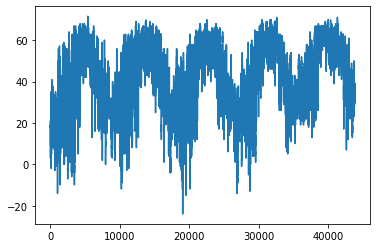

In [ ]:
weather_final['dwpf'].plot()

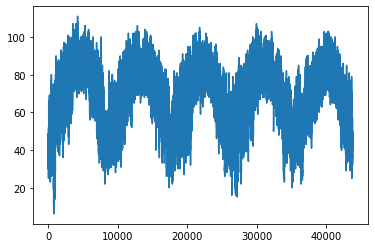

In [ ]:
weather_final['tmpf'].plot()

# Data Merging

In [ ]:
merged_data = weather_final.merge(energy_final, how = 'inner', on = 'valid_date')
merged_data

,valid_date,tmpf,dwpf,relh,sknt,weekend_indi,month,hour,tmpf_MA_12,tmpf_MA_24,tmpf_MA_48,dwpf_MA_12,dwpf_MA_24,dwpf_MA_48,relh_MA_12,relh_MA_24,relh_MA_48,MWh
0,2011-01-01 00:00:00,32.00,17.96,55.72,8.0,1,0,0,33.290,37.6775,37.82375,15.080,15.5000,15.36875,48.972500,42.097917,41.547083,28496.388850
1,2011-01-01 01:00:00,33.08,19.04,55.89,7.0,1,0,1,33.290,37.6775,37.82375,15.080,15.5000,15.36875,48.972500,42.097917,41.547083,27662.443480
2,2011-01-01 02:00:00,33.08,17.96,53.36,9.0,1,0,2,33.290,37.6775,37.82375,15.080,15.5000,15.36875,48.972500,42.097917,41.547083,27250.044715
3,2011-01-01 03:00:00,32.00,19.04,58.37,7.0,1,0,3,33.290,37.6775,37.82375,15.080,15.5000,15.36875,48.972500,42.097917,41.547083,26783.226081
4,2011-01-01 04:00:00,30.02,19.04,63.24,7.0,1,0,4,33.290,37.6775,37.82375,15.080,15.5000,15.36875,48.972500,42.097917,41.547083,26676.468490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43796,2015-12-30 20:00:00,44.96,33.98,65.18,4.0,0,11,20,50.675,43.3025,40.63625,32.915,32.0825,31.70375,51.993333,67.491667,72.653958,39674.167296
43797,2015-12-30 21:00:00,42.98,33.08,67.81,6.0,0,11,21,51.005,43.5950,40.82375,33.170,32.0825,31.76750,51.822500,66.602083,72.290833,39485.829257
43798,2015-12-30 22:00:00,41.00,33.98,75.88,7.0,0,11,22,50.585,43.7600,40.98875,33.335,32.1200,31.85000,53.330833,66.204167,72.030625,38711.458864
43799,2015-12-30 23:00:00,41.00,33.98,75.88,8.0,0,11,23,49.745,43.9250,41.15375,33.500,32.1575,31.95500,55.666667,65.806250,71.849792,37254.930151


In [ ]:
merged_data['valid_date'] = pd.to_datetime(merged_data['valid_date'])
merged_data = merged_data.set_index(merged_data['valid_date'])
merged_data = merged_data.sort_index()

In [ ]:
merged_data

,valid_date,tmpf,dwpf,relh,sknt,weekend_indi,month,hour,tmpf_MA_12,tmpf_MA_24,tmpf_MA_48,dwpf_MA_12,dwpf_MA_24,dwpf_MA_48,relh_MA_12,relh_MA_24,relh_MA_48,MWh
valid_date,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,32.00,17.96,55.72,8.0,1,0,0,33.290,37.6775,37.82375,15.080,15.5000,15.36875,48.972500,42.097917,41.547083,28496.388850
2011-01-01 01:00:00,2011-01-01 01:00:00,33.08,19.04,55.89,7.0,1,0,1,33.290,37.6775,37.82375,15.080,15.5000,15.36875,48.972500,42.097917,41.547083,27662.443480
2011-01-01 02:00:00,2011-01-01 02:00:00,33.08,17.96,53.36,9.0,1,0,2,33.290,37.6775,37.82375,15.080,15.5000,15.36875,48.972500,42.097917,41.547083,27250.044715
2011-01-01 03:00:00,2011-01-01 03:00:00,32.00,19.04,58.37,7.0,1,0,3,33.290,37.6775,37.82375,15.080,15.5000,15.36875,48.972500,42.097917,41.547083,26783.226081
2011-01-01 04:00:00,2011-01-01 04:00:00,30.02,19.04,63.24,7.0,1,0,4,33.290,37.6775,37.82375,15.080,15.5000,15.36875,48.972500,42.097917,41.547083,26676.468490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-30 20:00:00,2015-12-30 20:00:00,44.96,33.98,65.18,4.0,0,11,20,50.675,43.3025,40.63625,32.915,32.0825,31.70375,51.993333,67.491667,72.653958,39674.167296
2015-12-30 21:00:00,2015-12-30 21:00:00,42.98,33.08,67.81,6.0,0,11,21,51.005,43.5950,40.82375,33.170,32.0825,31.76750,51.822500,66.602083,72.290833,39485.829257
2015-12-30 22:00:00,2015-12-30 22:00:00,41.00,33.98,75.88,7.0,0,11,22,50.585,43.7600,40.98875,33.335,32.1200,31.85000,53.330833,66.204167,72.030625,38711.458864


In [ ]:
merged_data = merged_data.drop(["valid_date"], axis = 1)

In [ ]:
merged_data.head()

,tmpf,dwpf,relh,sknt,weekend_indi,month,hour,tmpf_MA_12,tmpf_MA_24,tmpf_MA_48,dwpf_MA_12,dwpf_MA_24,dwpf_MA_48,relh_MA_12,relh_MA_24,relh_MA_48,MWh
valid_date,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,32.00,17.96,55.72,8.0,1,0,0,33.29,37.6775,37.82375,15.08,15.5,15.36875,48.9725,42.097917,41.547083,28496.388850
2011-01-01 01:00:00,33.08,19.04,55.89,7.0,1,0,1,33.29,37.6775,37.82375,15.08,15.5,15.36875,48.9725,42.097917,41.547083,27662.443480
2011-01-01 02:00:00,33.08,17.96,53.36,9.0,1,0,2,33.29,37.6775,37.82375,15.08,15.5,15.36875,48.9725,42.097917,41.547083,27250.044715
2011-01-01 03:00:00,32.00,19.04,58.37,7.0,1,0,3,33.29,37.6775,37.82375,15.08,15.5,15.36875,48.9725,42.097917,41.547083,26783.226081
2011-01-01 04:00:00,30.02,19.04,63.24,7.0,1,0,4,33.29,37.6775,37.82375,15.08,15.5,15.36875,48.9725,42.097917,41.547083,26676.468490


In [ ]:
merged_data.isnull().sum()

tmpf            0
dwpf            0
relh            0
sknt            0
weekend_indi    0
month           0
hour            0
tmpf_MA_12      0
tmpf_MA_24      0
tmpf_MA_48      0
dwpf_MA_12      0
dwpf_MA_24      0
dwpf_MA_48      0
relh_MA_12      0
relh_MA_24      0
relh_MA_48      0
MWh             0
dtype: int64

In [ ]:
merged_data.loc['2011-01-01 00:00:00':'2014-12-31 23:59:59']

,tmpf,dwpf,relh,sknt,weekend_indi,month,hour,tmpf_MA_12,tmpf_MA_24,tmpf_MA_48,dwpf_MA_12,dwpf_MA_24,dwpf_MA_48,relh_MA_12,relh_MA_24,relh_MA_48,MWh
valid_date,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,32.00,17.96,55.72,8.0,1,0,0,33.290,37.6775,37.82375,15.080,15.5000,15.36875,48.972500,42.097917,41.547083,28496.388850
2011-01-01 01:00:00,33.08,19.04,55.89,7.0,1,0,1,33.290,37.6775,37.82375,15.080,15.5000,15.36875,48.972500,42.097917,41.547083,27662.443480
2011-01-01 02:00:00,33.08,17.96,53.36,9.0,1,0,2,33.290,37.6775,37.82375,15.080,15.5000,15.36875,48.972500,42.097917,41.547083,27250.044715
2011-01-01 03:00:00,32.00,19.04,58.37,7.0,1,0,3,33.290,37.6775,37.82375,15.080,15.5000,15.36875,48.972500,42.097917,41.547083,26783.226081
2011-01-01 04:00:00,30.02,19.04,63.24,7.0,1,0,4,33.290,37.6775,37.82375,15.080,15.5000,15.36875,48.972500,42.097917,41.547083,26676.468490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,19.94,19.94,100.00,0.0,0,11,19,19.940,21.7025,29.29250,19.745,21.6050,24.89000,98.115000,98.560417,87.335208,48373.161288
2014-12-31 20:00:00,21.02,19.94,95.51,5.0,0,11,20,20.030,21.4550,28.66625,19.745,21.3125,24.78500,98.055000,98.373333,88.577292,46976.297844
2014-12-31 21:00:00,21.02,19.94,95.51,4.0,0,11,21,20.120,21.1625,28.08500,19.820,20.9750,24.72125,97.995000,98.186250,89.821250,45404.436667


In [ ]:
merged_data.loc['2015-01-01 00:00:00':'2015-12-31 23:59:59']

,tmpf,dwpf,relh,sknt,weekend_indi,month,hour,tmpf_MA_12,tmpf_MA_24,tmpf_MA_48,dwpf_MA_12,dwpf_MA_24,dwpf_MA_48,relh_MA_12,relh_MA_24,relh_MA_48,MWh
valid_date,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,21.02,21.02,100.00,5.0,0,0,0,20.405,20.7200,26.46500,20.135,20.4875,24.55625,98.563333,97.999167,93.536042,40707.660350
2015-01-01 01:00:00,21.92,21.02,96.26,3.0,0,0,1,20.570,20.6750,26.00375,20.225,20.4050,24.49250,98.565833,98.028750,94.603750,39624.861027
2015-01-01 02:00:00,21.92,21.02,96.26,4.0,0,0,2,20.735,20.6300,25.54250,20.315,20.3225,24.45125,98.254167,97.872917,95.712917,39013.544802
2015-01-01 03:00:00,21.92,21.92,96.26,4.0,0,0,3,20.900,20.6300,25.12250,20.480,20.3225,24.42875,97.942500,97.717083,96.751458,38566.541927
2015-01-01 04:00:00,23.00,21.92,95.55,5.0,0,0,4,21.155,20.6750,24.89375,20.645,20.3225,24.36500,97.571667,97.687500,97.298750,38488.338511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-30 20:00:00,44.96,33.98,65.18,4.0,0,11,20,50.675,43.3025,40.63625,32.915,32.0825,31.70375,51.993333,67.491667,72.653958,39674.167296
2015-12-30 21:00:00,42.98,33.08,67.81,6.0,0,11,21,51.005,43.5950,40.82375,33.170,32.0825,31.76750,51.822500,66.602083,72.290833,39485.829257
2015-12-30 22:00:00,41.00,33.98,75.88,7.0,0,11,22,50.585,43.7600,40.98875,33.335,32.1200,31.85000,53.330833,66.204167,72.030625,38711.458864


# Exporatory Data Analysis

## Various Plots wrt Date and Energy

### tmpf

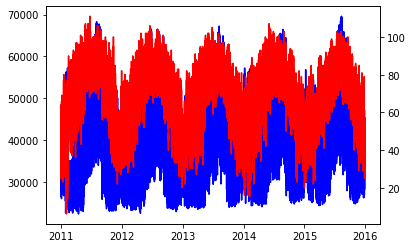

In [ ]:
merged_data.reset_index(inplace=True)
fig, ax = plt.subplots()

ax.plot(merged_data.valid_date, merged_data.MWh, color='blue')

ax2 = ax.twinx()

ax2.plot(merged_data.valid_date, merged_data.tmpf, color='red')

plt.show()

When we plot the temperature versus energy plot, we see that the peaks and troughs are similar between both. This shows that the tempoerature increases and decreases with energy. With higher temperature, higher energy consumption is shown since Texas has hot climate and air conditioners use this higher energy.

### sknt

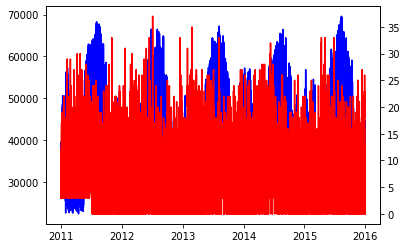

In [ ]:
fig, ax = plt.subplots()


ax.plot(merged_data.valid_date, merged_data.MWh, color='blue')
ax2 = ax.twinx()

ax2.plot(merged_data.valid_date, merged_data.sknt, color='red')

plt.show()

For wind speed (SKNT), there is not much correlatuon with respect to energy consumption. We can see that higher energy consumption is during low wind speeds as well as high wind speeds. 

### relh

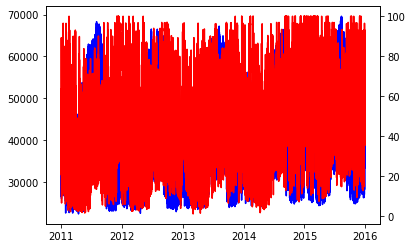

In [ ]:
fig, ax = plt.subplots()


ax.plot(merged_data.valid_date, merged_data.MWh, color='blue')


ax2 = ax.twinx()


ax2.plot(merged_data.valid_date, merged_data.relh, color='red')

plt.show()

With respect to relative humidity, there seems to be no correlation at all with energy consumption.

###dwpf

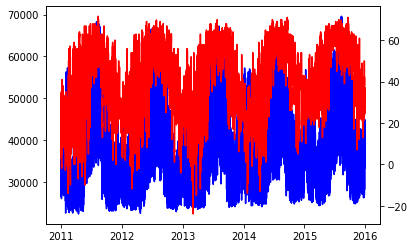

In [ ]:
fig, ax = plt.subplots()


ax.plot(merged_data.valid_date, merged_data.MWh, color='blue')


ax2 = ax.twinx()


ax2.plot(merged_data.valid_date, merged_data.dwpf, color='red')

plt.show()

A higher dew point leads to higher power consumption, whereas lower dew point leads to lower power consumption. A higher dew point means that temperature is very cold at those points as water forms droplets from air. This means more power is required to keep warm.

## Data average according to Hours of day

In [ ]:
MWh_hour = merged_data.pivot_table(index=['hour'], values=['MWh'], aggfunc='mean')
tmpf_hour = merged_data.pivot_table(index=['hour'], values=['tmpf'], aggfunc='mean')
relh_hour = merged_data.pivot_table(index=['hour'], values=['relh'], aggfunc='mean')
dwpf_hour = merged_data.pivot_table(index=['hour'], values=['dwpf'], aggfunc='mean')
sknt_hour = merged_data.pivot_table(index=['hour'], values=['sknt'], aggfunc='mean')

In [ ]:
hour_data = pd.concat([MWh_hour,tmpf_hour,relh_hour,dwpf_hour,sknt_hour],axis=1)
hour_data

,MWh,tmpf,relh,dwpf,sknt
hour,,,,,
0,35651.668784,63.042892,51.425515,42.212968,10.159912
1,33298.742285,61.871551,53.493205,42.434707,9.988493
2,31779.484842,60.908395,55.328690,42.588964,9.563836
3,30836.841342,59.927649,56.791041,42.519868,9.375890
4,30387.144039,58.991529,58.177600,42.372899,8.947945
5,30590.008852,58.127003,59.464619,42.154959,8.752877
6,31981.902880,57.358411,60.640192,41.986115,8.583014
7,34399.334349,56.557775,61.919479,41.831660,8.360548
8,35462.590651,56.795485,61.785764,41.972625,8.303562


## Data average according to Months of Year

In [ ]:
MWh_month = merged_data.pivot_table(index=['month'], values=['MWh'], aggfunc='mean')
tmpf_month = merged_data.pivot_table(index=['month'], values=['tmpf'], aggfunc='mean')
relh_month = merged_data.pivot_table(index=['month'], values=['relh'], aggfunc='mean')
dwpf_month = merged_data.pivot_table(index=['month'], values=['dwpf'], aggfunc='mean')
sknt_month = merged_data.pivot_table(index=['month'], values=['sknt'], aggfunc='mean')

In [ ]:
month_data=pd.concat([MWh_month,tmpf_month,relh_month,dwpf_month,sknt_month],axis=1)
month_data

,MWh,tmpf,relh,dwpf,sknt
month,,,,,
0,35593.185824,47.022161,47.868382,24.398726,8.343280
1,34575.789578,50.973404,45.190393,24.645266,9.362293
2,32029.173024,60.663510,39.965128,29.430579,9.580888
3,33557.197647,69.662100,32.919661,31.954000,10.272222
4,37364.127204,74.733210,40.214962,41.529839,10.321505
5,44961.158268,83.245450,44.418039,55.133200,11.583333
6,47071.682187,82.599392,47.338094,58.222516,9.568280
7,48866.274524,84.065559,42.709917,56.435651,8.474194
8,42694.063064,76.508350,52.117711,54.000750,8.414444


## Energy Consuption hourly and Monthly

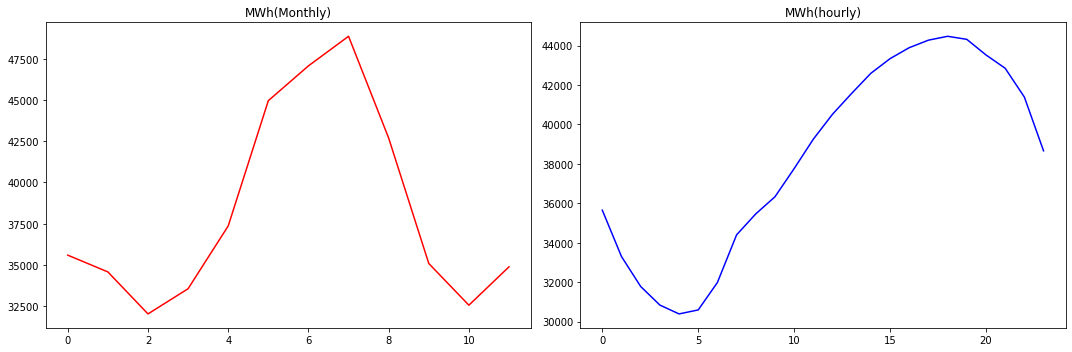

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(month_data['MWh'],color="red")
plt.title('MWh(Monthly)')

plt.subplot(122)
plt.plot(hour_data['MWh'],color="blue")
plt.title('MWh(hourly)')
plt.tight_layout()
plt.show()

# Modeling

In [ ]:
# split data into X and y
Y = merged_data['MWh']
X = merged_data.drop(['MWh'], axis=1)

In [ ]:
X

,tmpf,dwpf,relh,sknt,weekend_indi,tmpf_MA_12,tmpf_MA_24,tmpf_MA_48,dwpf_MA_12,dwpf_MA_24,dwpf_MA_48,relh_MA_12,relh_MA_24,relh_MA_48,month,hour
valid_date,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,32.00,17.96,55.72,8.0,1,33.290,37.6775,37.82375,15.080,15.5000,15.36875,48.972500,42.097917,41.547083,0,0
2011-01-01 01:00:00,33.08,19.04,55.89,7.0,1,33.290,37.6775,37.82375,15.080,15.5000,15.36875,48.972500,42.097917,41.547083,0,1
2011-01-01 02:00:00,33.08,17.96,53.36,9.0,1,33.290,37.6775,37.82375,15.080,15.5000,15.36875,48.972500,42.097917,41.547083,0,2
2011-01-01 03:00:00,32.00,19.04,58.37,7.0,1,33.290,37.6775,37.82375,15.080,15.5000,15.36875,48.972500,42.097917,41.547083,0,3
2011-01-01 04:00:00,30.02,19.04,63.24,7.0,1,33.290,37.6775,37.82375,15.080,15.5000,15.36875,48.972500,42.097917,41.547083,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-30 20:00:00,44.96,33.98,65.18,4.0,0,50.675,43.3025,40.63625,32.915,32.0825,31.70375,51.993333,67.491667,72.653958,11,20
2015-12-30 21:00:00,42.98,33.08,67.81,6.0,0,51.005,43.5950,40.82375,33.170,32.0825,31.76750,51.822500,66.602083,72.290833,11,21
2015-12-30 22:00:00,41.00,33.98,75.88,7.0,0,50.585,43.7600,40.98875,33.335,32.1200,31.85000,53.330833,66.204167,72.030625,11,22


In [ ]:
Y

valid_date
2011-01-01 00:00:00    28496.388850
2011-01-01 01:00:00    27662.443480
2011-01-01 02:00:00    27250.044715
2011-01-01 03:00:00    26783.226081
2011-01-01 04:00:00    26676.468490
                           ...     
2015-12-30 20:00:00    39674.167296
2015-12-30 21:00:00    39485.829257
2015-12-30 22:00:00    38711.458864
2015-12-30 23:00:00    37254.930151
2015-12-31 00:00:00    35517.364870
Name: MWh, Length: 43801, dtype: float64

In [ ]:
X_train = X['2011-01-01':'2014-12-31']
X_test = X['2015-01-01':'2015-12-31'] 
y_train = Y['2011-01-01':'2014-12-31']
y_test = Y['2015-01-01':'2015-12-31']

In [ ]:
from numpy import array

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, Y = list(), list()
	for i in np.arange(len(sequences)): # be careful of this line!
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		Y.append(seq_y)
	return np.array(X), np.array(Y)

In [ ]:
# all we need to do is decide on is n_steps (what our lookback period is)
# since we have a bunch of data, why not n_steps=10? then try 30 later on.
n_steps = 50
raw_seq = np.array(merged_data) #make sure your data is stored as a numpy array!
# let's ignore the date column and just use the temperature data
X, Y = split_sequences(raw_seq, n_steps=10)

In [ ]:
print(X.shape)
print(Y.shape)

(43792, 10, 16)
(43792,)


In [ ]:
35064/43801 #split between train and test data

0.8005296682724139

In [ ]:
train_pct_index = int(0.80055 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = Y[:train_pct_index], Y[train_pct_index:]

In [ ]:
print(X.shape, X_train.shape, X_test.shape)
print(Y.shape, y_train.shape, y_test.shape)

(43792, 10, 16) (35057, 10, 16) (8735, 10, 16)
(43792,) (35057,) (8735,)


In [ ]:
n_features = X.shape[2]
n_steps = X.shape[1]

print(n_steps, n_features)

10 16


In [ ]:
from keras.layers import Bidirectional
n_features = X.shape[2] # 31 green dot = 31 feature
n_steps = X.shape[1] # these are time steps = there are 10!

model = Sequential()
model.add((LSTM(30, return_sequences=True, activation='relu', input_shape=(n_steps, n_features))))
model.add((Bidirectional(LSTM(30, return_sequences=True,activation='relu'))))
model.add((Dense(50,activation='relu')))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['mae'])
model.summary()

es = EarlyStopping(monitor='val_mae', mode='min', 
                   patience=20, 
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
history = model.fit(X_train, y_train, 
          epochs=500, 
          batch_size=5, 
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 10, 30)            5640      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 10, 60)            14640     
_________________________________________________________________
dense_5 (Dense)              (None, 10, 50)            3050      
_________________________________________________________________
dense_6 (Dense)              (None, 10, 1)             51        
Total params: 23,381
Trainable params: 23,381
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
5609/5609 [==============================] - 48s 8ms/step - loss: 202187923.5465 - mae: 9896.1572 - val_loss: 26472236.0000 - val_mae: 4020.5479
Epoch 2/500
5609/5609 [==============================] - 45s 8ms/step - loss: 31951388.6032

# Analysis

## Energy Consuption for 2011

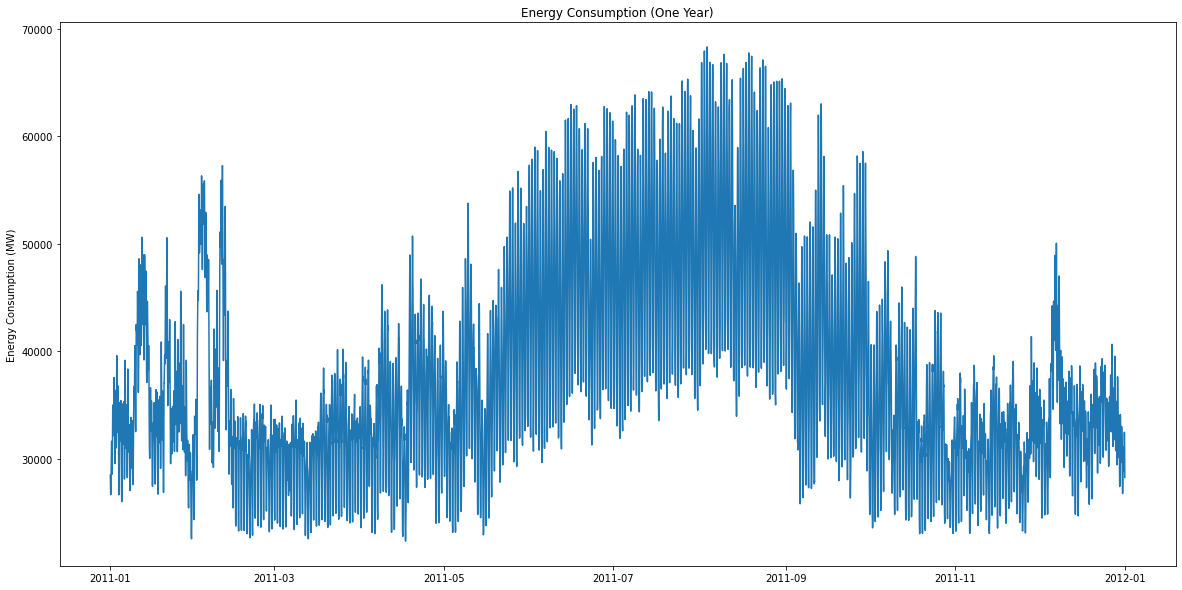

In [ ]:
YEAR_END_INDEX = 24*365
plt.figure(figsize=(20,10))
plt.plot(merged_data['valid_date'][:YEAR_END_INDEX], merged_data['MWh'][:YEAR_END_INDEX])
plt.title('Energy Consumption (One Year)')
plt.ylabel('Energy Consumption (MW)')
plt.show()

## Training

MAE of the model is:  2178.4383742536356


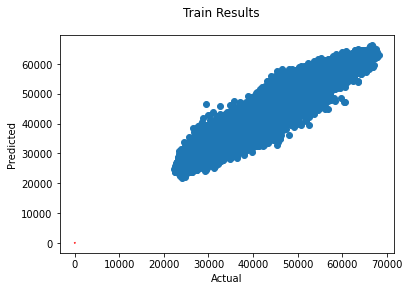

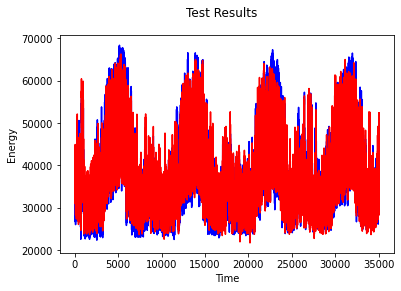

In [ ]:
# show scatterplots of actual vs. predicted for train and test
# make a prediction
pred = model.predict(X_train)# the pred

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE of the model is: ', mean_absolute_error(y_train, pred[: ,0, 0]))

actual = y_train # the actual
plt.scatter(x=actual, y=pred[: ,0, 0])
x = np.linspace(0,25) # 45 degree line from 0 to 25 (axes are the same)
plt.plot(x, x, color='red')
plt.suptitle('Train Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks pretty good!

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_train.shape[0]), y_train, color='blue') # actual data
plt.plot(np.arange(X_train.shape[0]), pred[: ,0, 0], color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

## Test

MAE of the MODEL is:  2267.0211454546507


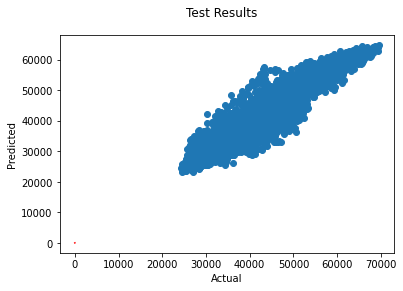

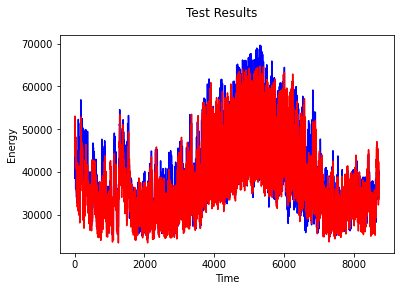

In [ ]:
# show scatterplots of actual vs. predicted for train and test
# make a prediction
pred = model.predict(X_test)# the pred

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE of the MODEL is: ', mean_absolute_error(y_test, pred[: ,0, 0]))

actual = y_test # the actual
plt.scatter(x=actual, y=pred[: ,0, 0])
x = np.linspace(0,25) # 45 degree line from 0 to 25 (axes are the same)
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred[: ,0, 0], color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

## Insights:

1. We tried various models as a part of our analysis but have included Bidirectional LSTM Model here, as it was our best model in terms of MAE( Mean Absolute Error). The MAE of the model(test) is 2267.02.(Best is 2064)

2. We have observed that MAE for both the training and train set is near about.(for test it is 2178.44).

3. The energy varies between 20K and 70K megawatts during the entire year.

4. From the energy consuption graph(monthly), it can deduced that their is a more consuption of energy between the month August and October and it decline after that.

5. From the energy consuption graph(hourly), it can deduced that their is a more consuption of energy during late afternoon and early evening(i.e. 15:00-19:00) and it decline after that.

6. We have built the time series plot and from it can be observed that the data is closely following the actual data and there is no overfitting issues here.

7. Closely monitoring the model and incorporating some changes in the model( type, layers, epoches) it can be used in real time to prevent such power outages in future.

8. We can also observe that with increase in Air Temperature in Fahrenheit, typically the energy consuption is increasing.